In [58]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC, Constant
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem

from scipy.stats import multivariate_normal
from scipy.stats import norm as normal
from scipy.stats import gamma

from scipy.linalg import lstsq
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import gmres

from firedrake.petsc import PETSc

import os
from pathlib import Path

from tqdm import tqdm, trange

%matplotlib inline

import matplotlib.pyplot as plt

global_plot_format = "eps"

fig_path = Path.home() / 'Dropbox' / 'phd' / 'projects' / 'stat-fem' / 'misc-notes' / 'lhs-uncertainty-images'

A4_INCHES_X = 8.3
A4_INCHES_Y = 11.7

font = {'size'   : 12}
plt.rc('font', **font)

In [59]:
class ThetaPriorGamma:
    
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self):
        return gamma.rvs(self.a, scale=self.b)
    
    def logpdf(self, theta):
        return gamma.logpdf(theta, self.a, scale=self.b)
    
    def tex_label(self):
        return "$\\theta \\sim$ Gamma$(0, 1)$"
    
class LogThetaPriorNormal:
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale

    def sample(self):
        return np.random.normal(loc=self.loc, scale=self.scale)
    
    def logpdf(self, log_theta):
        return normal.logpdf(log_theta, self.loc, self.scale)
    
    def tex_label(self):
        return "$\\log \\theta \\sim \\mathcal{N}(0, 1)$"
    
def theta_proposal_logpdf(theta_from, theta_to, prop_std):
    return normal.logpdf(theta_to, theta_from, prop_std)

def theta_proposal_sample(theta, prop_std):
    return np.random.normal(theta, prop_std)

is_prior_logscale = True

if is_prior_logscale:
    theta_prior = LogThetaPriorNormal(0, 1)
else:
    theta_prior = ThetaPriorGamma(1, 1)

In [97]:
experiment_label = 'basic'

mc_num_samples = 400_000
mcmc_num_samples = 10_000
num_samples_warmup = int(0.25 * mcmc_num_samples)
em_num_samples = 200

# Tuning the computations involving G
nugget = 0
# solve_G = lambda G, b: cg(G, b, atol=1e-10, M=np.diag(1 / np.diag(G)))[0]
# solve_G = lambda G, b: lstsq(G, b)[0]
# solve_G = lambda G, b: np.linalg.solve(G, b)
solve_G = lambda G, b: np.dot(np.linalg.pinv(G, hermitian=True), b)

solver_parameters = {
    'ksp_type': 'cg',
    'pc_type': 'sor',
    'pc_sor_symmetric': True
}

log_sigma_f = np.log(0.05)
log_l_f = np.log(0.1)

Max nonzero elements in a row: 333


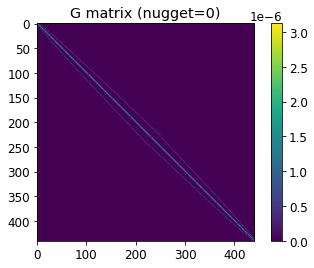

True
Distance of true $b$ from the recovered one $b$: 3.2987952989935822e-15


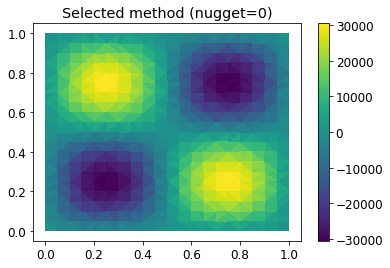

True
Distance of true $b$ from the recovered one $b$: 3.897551640927804e-16


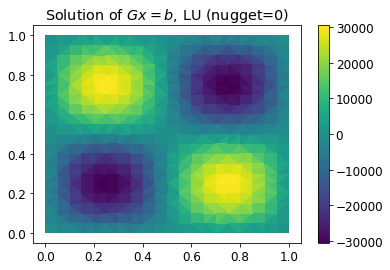

False
Distance of true $b$ from the recovered one $b$: 8.856159772528913e-06


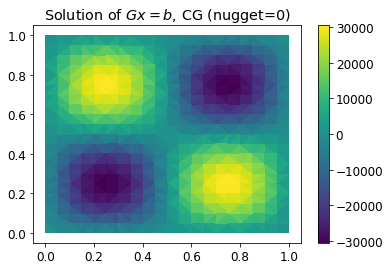

True
Distance of true b from the recovered one $b$: 3.2717312815492713e-15


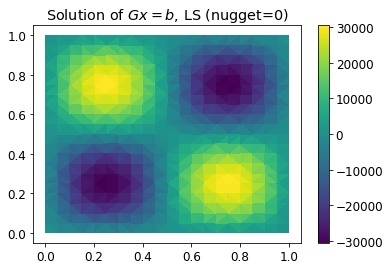

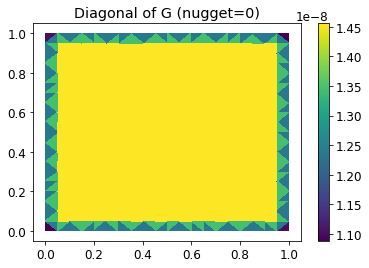

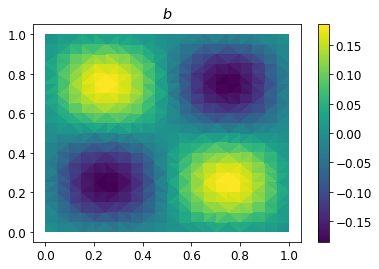

In [98]:
nx = 21
mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

M = mesh.coordinates.vector().dat.data.shape[0]
u = TrialFunction(V)
v = TestFunction(V)

f = Function(V)
x = SpatialCoordinate(mesh)

f.interpolate(-(8*pi*pi)*sin(x[0]*pi*2)*sin(x[1]*pi*2))

bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]
L = f * v * dx
b = assemble(L)
b_np = b.vector().dat.data

##
## Building G
##

from scipy.spatial.distance import cdist
ell_f = np.exp(log_l_f)
variance_f = np.exp(log_sigma_f) ** 2
XY_coords = mesh.coordinates.vector().dat.data
distances = cdist(XY_coords, XY_coords) / ell_f
K = variance_f * np.exp(-0.5 * np.square(distances))

# ED's way
# G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=1e-6)
# G.assemble()
# phi_integrated = np.array(assemble(Constant(1) * v * dx).vector().gather())
# G_np = np.zeros((M, M))
# for i in range(M):
#     for j in range(M):
# #         G_np[i, j] = phi_integrated[i] * K[i,j] * phi_integrated[j]
#         if i == j:
#             G_np[i, j] = phi_integrated[i] * K[i,j] * phi_integrated[j]
#             G_np[i, j] += nugget

# M K M way
# mass_mat = assemble(u*v*dx).petscmat.getValues(np.arange(M).astype(np.int32), np.arange(M).astype(np.int32))
# G_2 = np.dot(mass_mat, np.dot(np.diag(np.diag(K)), mass_mat))
# G_2 = G_2 + np.diag(np.repeat(nugget, M))
# G_np = G_2

# FC's way
temp = assemble(u*Constant(variance_f)*v*dx).petscmat.getValues(np.arange(M).astype(np.int32), np.arange(M).astype(np.int32))
G_np = temp + np.diag(np.repeat(nugget, M))

plt.figure()
plt.imshow(G_np)
plt.colorbar()
plt.title(f"G matrix (nugget={nugget})")
plt.show()

##
## Chosen method
##
fig, ax = plt.subplots()
lu_sol = solve_G(G_np, b_np)
print(np.allclose(np.dot(G_np, lu_sol), b_np))
print(f"Distance of true $b$ from the recovered one $b$: {np.linalg.norm(np.dot(G_np, lu_sol) - b_np, ord=2)}")
u_mean_plot_em = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              lu_sol)
ax.set_title(f"Selected method (nugget={nugget})")
fig.colorbar(u_mean_plot_em)
plt.show()

##
## LU
##
fig, ax = plt.subplots()
lu_sol = np.linalg.solve(G_np, b_np)
print(np.allclose(np.dot(G_np, lu_sol), b_np))
print(f"Distance of true $b$ from the recovered one $b$: {np.linalg.norm(np.dot(G_np, lu_sol) - b_np, ord=2)}")
u_mean_plot_em = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              lu_sol)
ax.set_title(f"Solution of $Gx=b$, LU (nugget={nugget})")
fig.colorbar(u_mean_plot_em)
plt.show()

##
## CG
##
fig, ax = plt.subplots()
cg_sol, cg_info = cg(G_np, b_np, atol=1e-12, M=np.diag(1 / np.diag(G_np)))
# cg_sol, cg_info = cg(G_np, b_np, tol=1e-12)
print(np.allclose(np.dot(G_np, cg_sol), b_np))
print(f"Distance of true $b$ from the recovered one $b$: {np.linalg.norm(np.dot(G_np, cg_sol) - b_np, ord=2)}")
u_mean_plot_em = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              cg_sol)
ax.set_title(f"Solution of $Gx=b$, CG (nugget={nugget})")
fig.colorbar(u_mean_plot_em)
plt.show()

##
## LS
##
fig, ax = plt.subplots()
ls_sol = lstsq(G_np, b_np)[0]
print(np.allclose(np.dot(G_np, ls_sol), b_np))
print(f"Distance of true b from the recovered one $b$: {np.linalg.norm(np.dot(G_np, ls_sol) - b_np, ord=2)}")
u_mean_plot_em = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              ls_sol)
ax.set_title(f"Solution of $Gx=b$, LS (nugget={nugget})")
fig.colorbar(u_mean_plot_em)
plt.show()

##
## Diagonal of G
##
fig, ax = plt.subplots()
diagGplot = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              np.diag(G_2))
ax.set_title(f"Diagonal of G (nugget={nugget})")
fig.colorbar(diagGplot)
plt.show()


##
## b
##
fig, ax = plt.subplots()
diagGplot = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              b_np)
ax.set_title(f"$b$")
fig.colorbar(diagGplot)
plt.show()

## Monte Carlo estimate

In [5]:
u_samples_mc = np.zeros((mc_num_samples, M))
u_cum_sum_mc = np.zeros(M)

with trange(mc_num_samples) as t:
    for n in t:
        theta_n = theta_prior.sample()
        if is_prior_logscale:
            theta_n = np.exp(theta_n)
        a = (dot(grad(v), Constant(theta_n) * grad(u))) * dx
        A = assemble(a, bcs=bc)
        u_mean = Function(V)
        solve(A, u_mean, b)
        u_samples_mc[n, :] = u_mean.vector().dat.data.copy()
        u_cum_sum_mc += u_mean.vector().dat.data
        
        t.set_description('Monte Carlo')
        t.set_postfix(estimate_l2=np.linalg.norm(u_cum_sum_mc / float(n+1), ord=2), 
                      cond_u = np.linalg.norm(u_mean.vector().dat.data, ord=2))

if is_prior_logscale:
    np.save(f"MC_samples_{mc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy", u_samples_mc)
else:
    np.save(f"MC_samples_{mc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy", u_samples_mc)

Monte Carlo: 100%|██████████| 400000/400000 [3:39:34<00:00, 30.36it/s, cond_u=32.8, estimate_l2=37.3]     


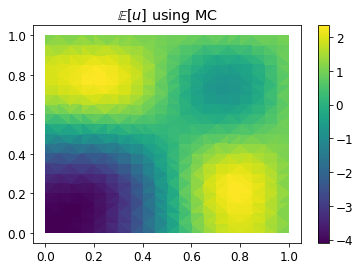

In [17]:
fig, ax = plt.subplots()
u_mean_plot_mc = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              np.mean(u_samples_mc, axis=0))
ax.set_title("$\\mathbb{E}[u]$ using MC")
fig.colorbar(u_mean_plot_mc)
plt.show()

## MCMC

In [ ]:
def log_likelihood(u: np.ndarray,
                   A: np.ndarray):
    
    (_, log_det_A) = np.linalg.slogdet(A) # A is pos. definite so sign ignored
    result = log_det_A
    result += np.dot(b_np, solve_G(G_np, np.dot(A, u)))
    result = result -0.5 * np.dot(u, np.dot(A, solve_G(G_np, np.dot(A, u))))
    return result

u_samples_mcmc = np.zeros((mcmc_num_samples, M))
theta_samples_mcmc = np.zeros(mcmc_num_samples)

u_cum_sum_mcmc = np.zeros(M)
warmup_interval_check = 50
accepted = 0

theta = np.exp(np.random.normal(0, 1e-1))
u_current = np.zeros(M)

prop_std = 1e-1 # initial value for the std of the proposal


with trange(mcmc_num_samples) as t:
    for n in t:
        # Recalibrate proposal density for theta 
        if n < num_samples_warmup and  ((n + 1) % warmup_interval_check == 0):
            ar = float(accepted) / float(warmup_interval_check)
            if ar < 0.4:
                print(f"AR = {ar} - rescaling the proposal density.")
                prop_std -= .1 * prop_std
                prop_std = np.abs(prop_std)
            elif ar > 0.6:
                print(f"AR = {ar} - rescaling the proposal density.")
                prop_std += .1 * prop_std 
            accepted = 0

        theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
        A = assemble((dot(grad(v), theta_constant * grad(u))) * dx, bcs=bc)

        u_mean = Function(V)
        solve(A, u_mean, b, solver_parameters=solver_parameters) # firedrake solve

        A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
        A_inv_np = np.linalg.pinv(A_np, hermitian=True)
        u_cov = A_inv_np @ G_np @ A_inv_np

        # 1. sample from p(u|theta, f) using a closed form expression
        u_current = np.random.multivariate_normal(u_mean.vector().dat.data, u_cov)

        # 2. sample from p(theta|u, f) via a Metropolis-step
        theta_star = theta_proposal_sample(theta, prop_std)

        if is_prior_logscale or theta_star > 0: # enforce the positivty
            theta_star_constant = Constant(np.exp(theta_star)) if is_prior_logscale else Constant(theta_star)
            A_star = assemble((dot(grad(v), theta_star_constant * grad(u))) * dx, bcs=bc)
            A_star_np = A_star.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
            
            u_mean_star = Function(V)
            solve(A_star, u_mean_star, b, solver_parameters=solver_parameters) # firedrake solve

            log_p_u_given_theta_star = log_likelihood(u_current, A_star_np)
            log_p_u_given_theta = log_likelihood(u_current, A_np)

            log_ar = log_p_u_given_theta_star + theta_prior.logpdf(theta_star) + theta_proposal_logpdf(theta_star, theta, prop_std)
            log_ar = log_ar - log_p_u_given_theta - theta_prior.logpdf(theta) - theta_proposal_logpdf(theta, theta_star, prop_std)

            if np.exp(log_ar) > np.random.uniform(0, 1):
                accepted += 1
                theta = theta_star

        theta_samples_mcmc[n] = theta
        u_samples_mcmc[n, :] = u_current
        u_cum_sum_mcmc += u_current
        
        t.set_description('MCMC')
        t.set_postfix(estimate_l2=np.linalg.norm(u_cum_sum_mcmc / float(n+1), ord=2), u=np.linalg.norm(u_current, ord=2), theta=theta)
    
if is_prior_logscale:
    np.save(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy", u_samples_mcmc)
else:
    np.save(f"MCMC_samples_{mcmc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy", u_samples_mcmc)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.linalg.norm(u_samples_mcmc, axis=1, ord=2))
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\Vert u_n \\Vert_2$')
ax.set_xlabel('$n$')
ax.set_title("Samples of $u$")
plt.show()

fig, ax = plt.subplots()
u_mean_plot_mcmc = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                                mesh.coordinates.vector().dat.data[:, 1],
                                np.mean(u_samples_mcmc[num_samples_warmup:], axis=0))
ax.set_title("$\\mathbb{E}[u]$ using MCMC")
fig.colorbar(u_mean_plot_mcmc)
plt.show()

fig, ax = plt.subplots()
ax.plot(np.exp(theta_samples_mcmc[num_samples_warmup:]) if is_prior_logscale else theta_samples_mcmc[num_samples_warmup:])
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\theta_n$')
ax.set_xlabel('$n$')
ax.set_title('Samples of $\\theta$')
plt.show()

# EM

In [99]:
from scipy.optimize import minimize_scalar as minimize

em_num_samples = 200

def e_step(theta):
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), Constant(theta_constant) * grad(u))) * dx, bcs=bc)
    
    u_mean = Function(V)
    solve(A, u_mean, b, solver_parameters=solver_parameters) # firedrake solve
    return u_mean.vector().dat.data

def m_step(theta, u_np, b_np):
    u = TrialFunction(V)
    v = TestFunction(V)
    M = u_np.shape[0]
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), theta_constant * grad(u))) * dx, bcs=bc)
    A_np = A.petscmat.getValues(np.arange(M).astype(np.int32), np.arange(M).astype(np.int32))
    
    (_, log_det) = np.linalg.slogdet(A_np) # A is pos. definite so sign ignored
    result = log_det
    result += theta_prior.logpdf(theta)
    
    result += np.dot(b_np, solve_G(G_np, np.dot(A_np, u_np)))
    result = result -0.5 * np.dot(u_np, np.dot(A_np, solve_G(G_np, np.dot(A_np, u_np))))
    
    return -1 * result

theta = np.random.normal(0, 1)
u_samples_em = np.zeros((em_num_samples, M))
theta_samples_em = np.zeros(em_num_samples)

with trange(em_num_samples) as t:
    for n in t:
        current_u = e_step(theta)
        u_samples_em[n, :] = current_u.copy()

        if is_prior_logscale:
            opt_result = minimize(m_step, args=(current_u, b_np), tol=1e-10) 
        else:
            opt_result = minimize(m_step, args=(current_u, b_np), xatol=1e-10, bounds=(0, np.inf), method='bounded')
        theta = opt_result.x
        theta_samples_em[n] = theta
        
        t.set_description('EM')
        t.set_postfix(estimate_l2=np.linalg.norm(current_u, ord=2))

if is_prior_logscale:
    np.save(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}", u_samples_em)
else:
    np.save(f"EM_samples_{em_num_samples}_gamma_prior_nx_{nx}_{experiment_label}", u_samples_em)    

EM: 100%|██████████| 200/200 [04:23<00:00,  1.32s/it, estimate_l2=46.1]


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.exp(theta_samples_em) if is_prior_logscale else em_theta_samples)
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\theta$')
ax.set_xlabel('Steps')
plt.show()

fig, ax = plt.subplots()
ax.plot(np.linalg.norm(u_samples_em, axis=1, ord=2))
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\Vert \hat{\\mathbb{E}}[u] \\Vert$')
ax.set_xlabel('Steps')
plt.show()

print(np.linalg.norm(u_samples_em[-1], ord=2))

fig, ax = plt.subplots()
u_mean_plot_em = ax.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                              mesh.coordinates.vector().dat.data[:, 1],
                              u_samples_em[-1])
ax.set_title("$\\hat{\\mathbb{E}}[u]$ using EM")
fig.colorbar(u_mean_plot_em)
plt.show()

# Convergence analysis

## $\log \theta \sim \mathcal{N}(0, 1)$ vs $p(\theta) \propto \vert A_\theta^{-1} \vert$

In [ ]:
u_samples_mcmc_logdet = np.load(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_theta_prior_logdetA_trick.npy")
u_samples_mcmc_normal = np.load(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_basic.npy")
em_u_samples_logdet = np.load(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_theta_prior_logdetA_trick.npy")
em_u_samples_normal = np.load(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_basic.npy")

In [ ]:
mcmc_cum_mean_logdet = np.cumsum(u_samples_mcmc_logdet[num_samples_warmup:], axis=0) / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]
mcmc_cum_mean_normal = np.cumsum(u_samples_mcmc_normal[num_samples_warmup:], axis=0) / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]

mcmc_cum_mse_logdet = np.sum(np.square(mcmc_cum_mean_logdet - mcmc_cum_mean_logdet[-1][np.newaxis, :]), axis=1)
mcmc_cum_mse_normal = np.sum(np.square(mcmc_cum_mean_normal - mcmc_cum_mean_normal[-1][np.newaxis, :]), axis=1)

max_N = mcmc_cum_mean_logdet.shape[0]
selected_range = np.arange(0, max_N)

global_plot_format = 'eps'

# convergence to the solution and MSE
fig, ax = plt.subplots(figsize=(1 * A4_INCHES_X, 1 * A4_INCHES_Y), nrows=2, ncols=1)
ax[0].plot(selected_range, np.linalg.norm(mcmc_cum_mean_logdet[selected_range], axis=1, ord=2), color='blue')
ax[0].plot(selected_range, np.linalg.norm(mcmc_cum_mean_normal[selected_range], axis=1, ord=2), color='orange')
ax[0].axhline(np.linalg.norm(em_u_samples_logdet[-1], ord=2), color='blue', linestyle='--')
ax[0].axhline(np.linalg.norm(em_u_samples_normal[-1], ord=2), color='orange', linestyle='--')
ax[0].legend(['$MCMC: p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert$', '$MCMC: \\log \\theta \\sim \\mathcal{N}(0, 1)$', 
           '$EM: p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert$', '$EM: \\log \\theta \\sim \\mathcal{N}(0, 1)$'])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('$\Vert \\hat{\\mathbb{E}}_{u|f}[u] \Vert_2$')
ax[0].set_xlabel('$N$')
ax[0].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$")

ax[1].plot(selected_range[:-2000], mcmc_cum_mse_logdet[selected_range[:-2000]])
ax[1].plot(selected_range[:-2000], mcmc_cum_mse_normal[selected_range[:-2000]])
ax[1].legend(['MCMC: : $p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert$', 'MCMC: $\\log \\theta \\sim \\mathcal{N}(0, 1)$'])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$N$')
ax[1].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$")
plt.tight_layout()
plt.savefig(fig_path / f'logdet-trick-convergence.{global_plot_format}', bbox_inches="tight")
plt.show()

# difference in the estimates

fig = plt.figure(figsize=(1 * A4_INCHES_X, 1 * A4_INCHES_Y))
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0))

# fig, ax = plt.subplots(figsize=(0.6 * A4_INCHES_X, 0.35 * A4_INCHES_Y), nrows=1, ncols=3)
ax1.plot(selected_range, np.linalg.norm(mcmc_cum_mean_logdet[selected_range] - mcmc_cum_mean_normal[selected_range], axis=1, ord=2))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel("$\\Vert \\hat{\\mathbb{E}}_{u|f, p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert}[u] - \\hat{\\mathbb{E}}_{u|f, \\log \\theta \\sim \\mathcal{N}(0, 1)}[u] \\Vert_2 $")
ax1.set_xlabel('$N$')
ax1.set_title("Difference in the expected solutions (MCMC only)")
# plt.savefig(fig_path / f'logdet-trick-solution-difference-norm.{global_plot_format}', bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots(figsize=(0.4 * A4_INCHES_X, 0.35 * A4_INCHES_Y))
diff_mcmc_mc_u = ax2.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
                               mesh.coordinates.vector().dat.data[:, 1],
                               np.abs(mcmc_cum_mean_normal[-1] - mcmc_cum_mean_logdet[-1]))
cbar = fig.colorbar(diff_mcmc_mc_u)
cbar.ax.set_ylabel('$\\vert \\mathbb{E}_{u|f, p(\\theta) \\propto \\vert A_\\theta^{-1} \\vert}[u] - \\mathbb{E}_{u|f, \\log \\theta \\sim \\mathcal{N}(0, 1)}[u] \\vert $')
ax2.set_title("Difference in the expected solutions (MCMC only)")
plt.tight_layout()
plt.savefig(fig_path / f'logdet-trick-solution-difference.{global_plot_format}', bbox_inches="tight")
plt.show()

## Monte Carlo, MCMC, and EM

In [ ]:
if is_prior_logscale:
    u_samples_mc = np.load(f"MC_samples_{mc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy")
    u_samples_mcmc = np.load(f"MCMC_samples_{mcmc_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy")
#     u_samples_em = np.load(f"EM_samples_{em_num_samples}_lognormal_prior_nx_{nx}_{experiment_label}.npy")
else:
    u_samples_mc = np.load(f"MC_samples_{mc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy")
    u_samples_mcmc = np.load(f"MCMC_samples_{mcmc_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy")
#     u_samples_em = np.load(f"EM_samples_{em_num_samples}_gamma_prior_nx_{nx}_{experiment_label}.npy")

mc_cum_mean = np.cumsum(u_samples_mc, axis=0) / (1 + np.arange(mc_num_samples))[:, np.newaxis]
mc_cum_mean_norm = np.linalg.norm(mc_cum_mean, axis=1)
true_mc_u_mean = mc_cum_mean[-1]
mc_cum_mse = np.sum(np.square(mc_cum_mean - true_mc_u_mean[np.newaxis, :]), axis=1)

mcmc_cum_mean = np.cumsum(u_samples_mcmc[num_samples_warmup:], axis=0) / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]
mcmc_cum_mean_extended = np.zeros(mc_cum_mean.shape)
mcmc_cum_mean_extended[:(mcmc_cum_mean.shape[0]), :] = mcmc_cum_mean
mcmc_cum_mean_extended[(mcmc_cum_mean.shape[0]):, :] = mcmc_cum_mean[-1, :]

true_mcmc_u_mean = mcmc_cum_mean[-1]

mcmc_cum_mean_norm = np.zeros(mc_cum_mean.shape[0])
mcmc_cum_mean_norm[:(mcmc_cum_mean.shape[0])] = np.linalg.norm(mcmc_cum_mean, axis=1, ord=2)
mcmc_cum_mean_norm[mcmc_cum_mean.shape[0]:] = mcmc_cum_mean_norm[mcmc_cum_mean.shape[0] - 1] # just replicate the last value

mcmc_cum_mse = np.zeros(mc_cum_mean.shape[0])
mcmc_cum_mse[:(mcmc_cum_mean.shape[0])] = np.sum(np.square(mcmc_cum_mean - true_mcmc_u_mean[np.newaxis, :]), axis=1)
mcmc_cum_mse[mcmc_cum_mean.shape[0]:] = mcmc_cum_mse[mcmc_cum_mean.shape[0] - 1] # just replicate

In [ ]:
max_N = min(mc_cum_mse.shape[0], mcmc_cum_mse.shape[0])
selected_range = np.arange(0, max_N)


# convergence
fig, ax = plt.subplots(figsize=(1 * A4_INCHES_X, 1 * A4_INCHES_Y), nrows=2, ncols=1)
# ax[0].plot(selected_range, mcmc_cum_mean_norm[selected_range], c='blue')
ax[0].plot(selected_range, mc_cum_mean_norm[selected_range], c='orange')
ax[0].axhline(np.linalg.norm(u_samples_em[-1], ord=2), c='green')
# ax[0].legend(['MCMC', 'MC', 'EM'])
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('$\Vert \\hat{\\mathbb{E}}_{u|f}[u] \Vert_2$')
ax[0].set_xlabel('$N$')
ax[0].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$ \n" + theta_prior_tex_label)

ax[1].plot(selected_range[:-2000], mcmc_cum_mse[selected_range[:-2000]])
ax[1].plot(selected_range[:-2000], mc_cum_mse[selected_range[:-2000]])
ax[1].legend(['MCMC', 'MC'])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$N$')
ax[1].set_title("Convergence of $\\hat{\\mathbb{E}}_{u|f}[u]$\n" + theta_prior_tex_label)

plt.tight_layout()
plt.savefig(fig_path / f'lognormal_convergence.{global_plot_format}', bbox_inches="tight")
plt.show()


# # difference in the estimates
# fig = plt.figure(figsize=(1 * A4_INCHES_X, 0.8 * A4_INCHES_Y))
# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# ax2 = plt.subplot2grid((2, 2), (1, 0))
# ax3 = plt.subplot2grid((2, 2), (1, 1))

# ax1.plot(selected_range, np.linalg.norm(mcmc_cum_mean[selected_range] - mc_cum_mean[selected_range], axis=1, ord=2))
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax1.set_ylabel("$\\Vert \\hat{\\mathbb{E}}_{u|f, MCMC}[u] - \\hat{\\mathbb{E}}_{u|f, MC}[u] \\Vert_2 $")
# ax1.set_xlabel('$N$')
# ax1.set_title("Difference in the estimates\n" + theta_prior_tex_label)

# diff_mcmc_mc_u = ax2.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
#                                mesh.coordinates.vector().dat.data[:, 1],
#                                np.abs(mcmc_cum_mean[-1] - mc_cum_mean[-1]))
# fig.colorbar(diff_mcmc_mc_u, ax=ax2)
# ax2.set_title("Difference in the estimates \n $\\vert \hat{\\mathbb{E}}_{u|f, MCMC}[u] - \hat{\\mathbb{E}}_{u|f, MC}[u] \\vert $\n" + theta_prior_tex_label)

# diff_mcmc_em_u = ax3.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
#                                mesh.coordinates.vector().dat.data[:, 1],
#                                np.abs(mcmc_cum_mean[-1] - u_samples_em[-1]))
# fig.colorbar(diff_mcmc_em_u, ax=ax3)
# ax3.set_title("Difference in the estimates \n $\\vert \hat{\\mathbb{E}}_{u|f, MCMC}[u] - \hat{\\mathbb{E}}_{u|f, EM}[u] \\vert $\n" + theta_prior_tex_label)

# plt.tight_layout()
# plt.savefig(fig_path / f'lognormal_solution_difference.{global_plot_format}', bbox_inches="tight")
# plt.show()